In [ ]:
import polars as pl
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc 

DATA_FOLDER = "nyc_data"
all_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "**/*.parquet")))

print(f"Found {len(all_files)} files.")

if len(all_files) == 0:
    print("No files found! Check your folder path.")
    exit()

# Storage for results
monthly_accum = []
hourly_accum = []
sample_df = None # To store data for Plot 4

Found 119 files.


In [ ]:
for i, file_path in enumerate(all_files):
    try:
        # Lazy scan
        q = pl.scan_parquet(file_path)
        
        # --- A. Standardize Column Names ---
        # Normalize columns (some files use 'Trip_Distance', others 'trip_distance')
        actual_columns = q.columns
        rename_map = {}
        for col in actual_columns:
            if col.lower() == "tpep_pickup_datetime": rename_map[col] = "tpep_pickup_datetime"
            if col.lower() == "tpep_dropoff_datetime": rename_map[col] = "tpep_dropoff_datetime"
            if col.lower() == "trip_distance": rename_map[col] = "trip_distance"
            if col.lower() == "total_amount": rename_map[col] = "total_amount"
        
        if rename_map:
            q = q.rename(rename_map)

        # Check required columns
        required = {"tpep_pickup_datetime", "trip_distance", "total_amount"}
        if not required.issubset(set(q.columns)):
            continue

        # --- B. Filter & Feature Engineering ---
        q = (
            q.select(["tpep_pickup_datetime", "trip_distance", "total_amount"])
            .filter(
                (pl.col("trip_distance") > 0) & (pl.col("trip_distance") < 1000) &
                (pl.col("total_amount") > 0) & (pl.col("total_amount") < 1000)
            )
            .with_columns([
                pl.col("tpep_pickup_datetime").dt.year().alias("year"),
                pl.col("tpep_pickup_datetime").dt.month().alias("month"),
                pl.col("tpep_pickup_datetime").dt.hour().alias("hour")
            ])
            .filter((pl.col("year") >= 2016) & (pl.col("year") <= 2025))
        )

        # --- C. Capture Sample for Plot 4 (The Fix) ---
        # We grab this from the FIRST valid file we see, then stop checking.
        if sample_df is None:            
            # 1. Select specific column & Filter
            q_hist = q.select("trip_distance")
            
            # 2. COLLECT FIRST (Load into RAM), THEN SAMPLE
            # This avoids the LazyFrame.sample() error
            df_hist = q_hist.collect() 
            
            # 3. Sample if we have enough rows
            if len(df_hist) > 100000:
                sample_df = df_hist.sample(n=100000, seed=42).to_pandas()
            else:
                sample_df = df_hist.to_pandas()
            
            # Free memory immediately
            del df_hist, q_hist
            gc.collect()

        # --- D. Aggregations for Trends ---
        
        # 1. Monthly Partial Stats
        monthly_batch = (
            q.group_by(["year", "month"])
            .agg([
                pl.len().alias("count"),
                pl.col("total_amount").sum().alias("sum_fare"),
                pl.col("trip_distance").sum().alias("sum_distance")
            ])
            .collect()
        )
        monthly_accum.append(monthly_batch)

        # 2. Hourly Partial Stats
        hourly_batch = (
            q.group_by("hour")
            .agg(pl.len().alias("count"))
            .collect()
        )
        hourly_accum.append(hourly_batch)

        # Clean up memory
        del q, monthly_batch, hourly_batch
        gc.collect()

        # Progress indicator
        if i % 5 == 0:
            print(f"Processed {i+1}/{len(all_files)} files...")

    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")


In [5]:
# 3. MERGE RESULTS
if monthly_accum:
    df_monthly_total = pl.concat(monthly_accum)
    
    final_monthly = (
        df_monthly_total
        .group_by(["year", "month"])
        .agg([
            pl.col("count").sum().alias("total_trips"),
            pl.col("sum_fare").sum().alias("total_fare_amt"),
            pl.col("sum_distance").sum().alias("total_dist_amt")
        ])
        .with_columns([
            (pl.col("total_fare_amt") / pl.col("total_trips")).alias("avg_fare"),
            (pl.col("total_dist_amt") / pl.col("total_trips")).alias("avg_distance")
        ])
        .sort(["year", "month"])
    )
else:
    print("No valid data processed.")
    exit()

if hourly_accum:
    df_hourly_total = pl.concat(hourly_accum)
    final_hourly = (
        df_hourly_total
        .group_by("hour")
        .agg(pl.col("count").sum().alias("total_trips"))
        .sort("hour")
    )


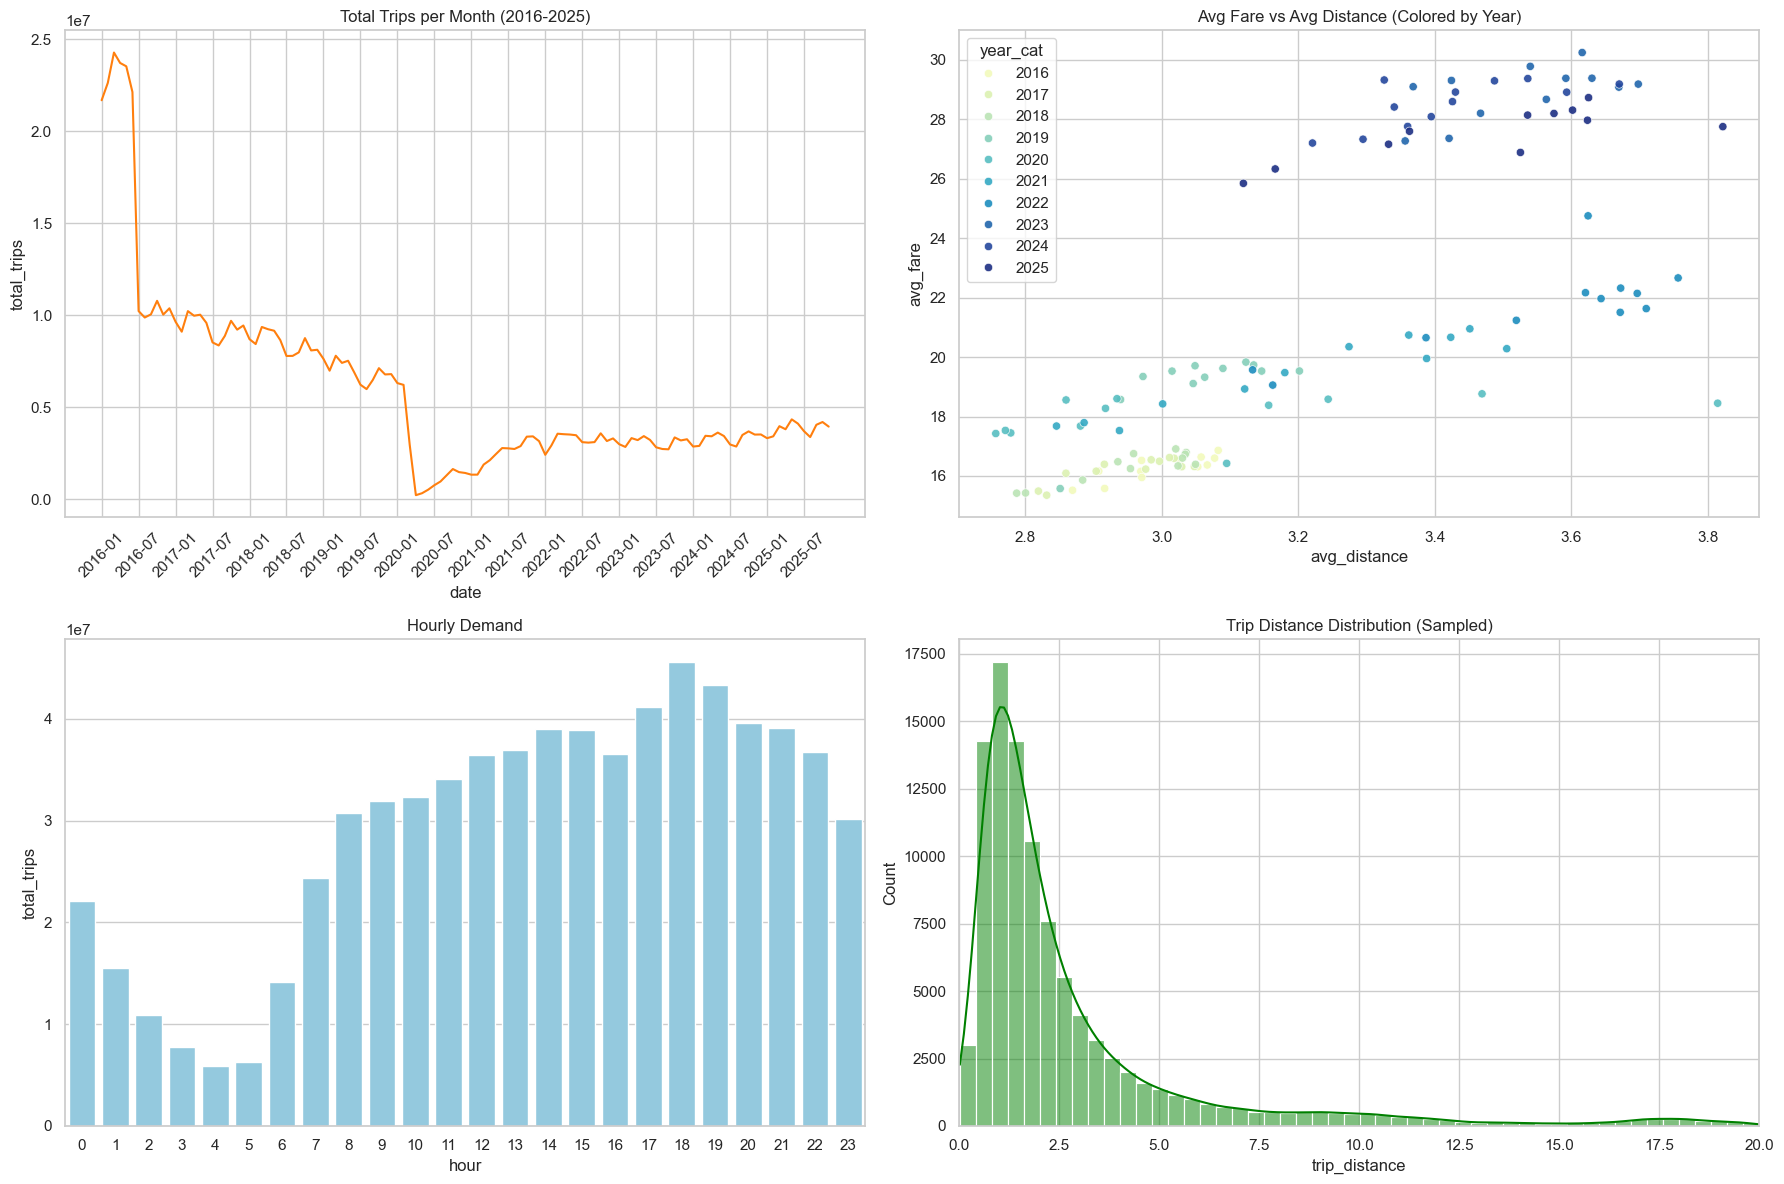

In [11]:
# 4. VISUALIZATION & OUTPUT
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Convert to Pandas
pdf_monthly = final_monthly.to_pandas()
pdf_hourly = final_hourly.to_pandas()

# Create 'date' column for plotting
pdf_monthly['date'] = pdf_monthly['year'].astype(str) + '-' + pdf_monthly['month'].astype(str).str.zfill(2)

# Plot 1: Monthly Trends
sns.lineplot(data=pdf_monthly, x='date', y='total_trips', ax=axes[0, 0], color='#ff7f0e')
axes[0, 0].set_title("Total Trips per Month (2016-2025)")
ticks = axes[0, 0].get_xticks()
axes[0, 0].set_xticks(ticks[::6]) # Reduce labels
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Economics
# Create a string version of year so Seaborn treats it as a category
pdf_monthly['year_cat'] = pdf_monthly['year'].astype(str)

# Sort so the legend is in order
pdf_monthly = pdf_monthly.sort_values('year')

# PLOT 2: Economics
# Change 'hue' to the new string column
# Change 'palette' to 'tab10' or 'deep' (distinct colors instead of a gradient)
sns.scatterplot(
    data=pdf_monthly, 
    x='avg_distance', 
    y='avg_fare', 
    palette='YlGnBu',
    hue='year_cat',       # <--- USE CATEGORICAL YEAR
    alpha=0.9,            # <--- Make dots slightly transparent
    ax=axes[0, 1]
)
axes[0, 1].set_title("Avg Fare vs Avg Distance (Colored by Year)")

# Plot 3: Hourly
sns.barplot(data=pdf_hourly, x='hour', y='total_trips', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title("Hourly Demand")

# Plot 4: Distribution
if sample_df is not None and not sample_df.empty:
    sns.histplot(data=sample_df, x='trip_distance', bins=50, kde=True, ax=axes[1, 1], color='green')
    axes[1, 1].set_title("Trip Distance Distribution (Sampled)")
    axes[1, 1].set_xlim(0, 20)
else:
    axes[1, 1].text(0.5, 0.5, "No Data for Histogram", ha='center')

plt.tight_layout()
plt.show()

# Save Data
pdf_monthly.to_csv("eda_data/nyc_taxi_monthly_summary.csv", index=False)
pdf_hourly.to_csv("eda_data/nyc_taxi_hourly_summary.csv", index=False)

In [ ]:
import polars as pl
import glob
import os
import shutil
import gc
import numpy as np

# ==========================================
# 1. SETUP
# ==========================================
DATA_FOLDER = "nyc_data"
TEMP_FOLDER = "temp_chunks"

# Clean/Create temp folder
if os.path.exists(TEMP_FOLDER):
    shutil.rmtree(TEMP_FOLDER)
os.makedirs(TEMP_FOLDER)

all_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "**/*.parquet")))
print(f"Found {len(all_files)} raw files.")

# ==========================================
# 2. PHASE 1: MAP (Process & Write to Disk)
# ==========================================
print(f"Starting Phase 1: Processing to {TEMP_FOLDER}...")

for i, file_path in enumerate(all_files):
    try:
        # 1. Scan without schema_overrides (Fix for older Polars)
        q = pl.scan_parquet(file_path)
        
        # 2. Handle Column Renaming (Normalization)
        cols = [c.lower() for c in q.columns]
        
        # Check if required columns exist (case-insensitive)
        if "tpep_pickup_datetime" in cols:
            time_col = "tpep_pickup_datetime"
        else:
            # Skip file if no timestamp
            continue
            
        # Find Location ID column
        loc_col = "PULocationID" if "pulocationid" in cols else None
        if not loc_col:
             # Try checking for case variants if needed, or skip
             continue

        # 3. Select, Cast, and Aggregate
        # We explicitly CAST inside the query to fix schema issues
        chunk_agg = (
            q
            .select([
                pl.col(time_col).alias("tpep_pickup_datetime"),
                pl.col(loc_col).alias("PULocationID")
            ])
            # Force types to match across all files
            .with_columns([
                pl.col("PULocationID").cast(pl.Int64),
                pl.col("tpep_pickup_datetime").cast(pl.Datetime)
            ])
            # Filter garbage
            .filter((pl.col("PULocationID") < 266) & (pl.col("PULocationID") > 0))
            # Truncate to Hour
            .with_columns(
                pl.col("tpep_pickup_datetime").dt.truncate("1h").alias("pickup_hour")
            )
            # Aggregate: Count trips per Hour per Location
            .group_by(["pickup_hour", "PULocationID"])
            .agg(pl.len().alias("demand"))
            .collect() # Materialize small chunk
        )
        
        # 4. Write to Disk (Saves RAM)
        if len(chunk_agg) > 0:
            output_name = os.path.join(TEMP_FOLDER, f"chunk_{i}.parquet")
            chunk_agg.write_parquet(output_name)
            print(f"[{i+1}/{len(all_files)}] Saved {output_name} ({len(chunk_agg)} rows)")
        
        # 5. Clear Memory
        del q, chunk_agg
        gc.collect()

    except Exception as e:
        print(f"Skipping file {i}: {e}")

In [ ]:
# ==========================================
# 3. PHASE 2: REDUCE (Merge Small Files)
# ==========================================
print("\nPhase 2: Merging processed chunks...")

# Scan the processed folder (LAZY mode)
q_final = pl.scan_parquet(os.path.join(TEMP_FOLDER, "*.parquet"))

# 1. Filter Date Outliers EARLY
# Adjust these years based on your actual dataset needs
VALID_START_YEAR = 2016
VALID_END_YEAR = 2025

q_final = q_final.filter(
    (pl.col("pickup_hour").dt.year() >= VALID_START_YEAR) & 
    (pl.col("pickup_hour").dt.year() <= VALID_END_YEAR)
)

# 2. Re-group and Collect History
# We collect here because we need the real min/max dates and top locations
# Since we filtered dates, this will be much smaller/safer.
df_history = (
    q_final
    .group_by(["pickup_hour", "PULocationID"])
    .agg(pl.col("demand").sum())
    .collect()
)

print(f"Total History Loaded: {len(df_history)} rows")

if len(df_history) == 0:
    print("Error: No data found after date filtering. Check VALID_START_YEAR/VALID_END_YEAR.")
    exit()

# ==========================================
# 4. PHASE 3: ZERO-FILLING & ML FEATURES
# ==========================================
print("Phase 3: Creating ML Features (Zero-Filling)...")

# 1. Select Top 50 Locations
top_locs_df = (
    df_history.group_by("PULocationID")
    .agg(pl.col("demand").sum())
    .sort("demand", descending=True)
    .head(50) 
    .select("PULocationID")
)

# 2. Create Time Grid (Safe now due to filtering)
min_date = df_history["pickup_hour"].min()
max_date = df_history["pickup_hour"].max()
print(f"Time range: {min_date} to {max_date}")

full_timeline = pl.datetime_range(min_date, max_date, interval="1h", eager=True).alias("pickup_hour").to_frame()

# 3. Create Grid (Lazy)
# Convert to lazy immediately to save RAM during the join
lz_timeline = full_timeline.lazy()
lz_locs = top_locs_df.lazy()

# Cross Join
lz_grid = lz_timeline.join(lz_locs, how="cross")

# 4. Join Data & Fill Nulls (Lazy)
lz_history = df_history.lazy()

lz_ml = (
    lz_grid
    .join(lz_history, on=["pickup_hour", "PULocationID"], how="left")
    .with_columns(pl.col("demand").fill_null(0))
    .sort(["PULocationID", "pickup_hour"])
)

# 5. Add Lag Features (Lazy)
print("Adding Lag Features definition...")
lz_features = (
    lz_ml
    .with_columns([
        # Time components
        pl.col("pickup_hour").dt.year().alias("year"),
        pl.col("pickup_hour").dt.month().alias("month"),
        pl.col("pickup_hour").dt.weekday().alias("day_of_week"),
        pl.col("pickup_hour").dt.hour().alias("hour"),
        
        # Historical Lags
        pl.col("demand").shift(1).over("PULocationID").alias("lag_1h"),
        pl.col("demand").shift(24).over("PULocationID").alias("lag_24h"),
        pl.col("demand").shift(168).over("PULocationID").alias("lag_7d"),
    ])
    .filter(pl.col("lag_7d").is_not_null()) # Remove first week of empty lags
)

# ==========================================
# 5. SAVE FINAL DATASET (STREAMING)
# ==========================================
output_file = "eda_data/nyc_taxi_demand_ml_ready.parquet"
print(f"Streaming result to {output_file}...")

# sink_parquet processes the data in batches, never holding the whole result in RAM.
lz_features.sink_parquet(output_file)

print("\n" + "="*40)
print(f"SUCCESS! ML Dataset saved to: {output_file}")
print("="*40)

# Optional: Cleanup
# shutil.rmtree(TEMP_FOLDER)


Phase 2: Merging processed chunks...
Total History Loaded: 10559078 rows
Phase 3: Creating ML Features (Zero-Filling)...
Time range: 2016-01-01 00:00:00 to 2025-11-30 23:00:00
Adding Lag Features definition...
Streaming result to eda_data/nyc_taxi_demand_ml_ready.parquet...

SUCCESS! ML Dataset saved to: eda_data/nyc_taxi_demand_ml_ready.parquet
